In [1]:
import sys
print('sys:'+sys.version)
import ddgs
print('ddgs:'+ddgs.__version__)
import fastai
print('fastai:'+fastai.__version__)

sys:3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]
ddgs:9.5.4
fastai:2.8.4


In [2]:
from ddgs import DDGS 
from fastcore.all import *
from itertools import islice
import random
import time
def search_images(keywords, max_images=200):
    # Try 'de-de' region first, then fallback to default
    regions = ['de-de','uk-en', 'us-en', 'fr-fr','ar-es', 'pl-pl', 'cn-zh','ar-en', 'pl-en', 'cn-en']
    for region in regions:
        try:
            with DDGS(timeout=20) as ddgs:
                return L(r['image'] for r in islice(ddgs.images(query=keywords, region=region), max_images))
        except:
            time.sleep(random.uniform(1.2, 3.6))
            continue
    return L() 

In [3]:
import time, json
from fastdownload import download_url
from fastai.vision.all import *
download_url(search_images('Indoor', max_images=1)[0], 'indoor.jpg')

Path('indoor.jpg')

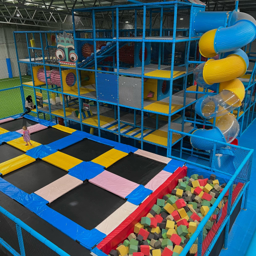

In [4]:
Image.open('indoor.jpg').to_thumb(256,256)

In [5]:
# area_types = [
#     "Indoor",
#     "Outdoor",
# ]

# path = Path('area_types')

# import requests
# for o in area_types:
#     dest = (path/o)
#     dest.mkdir(parents=True, exist_ok=True)
#     print(f"Searching and downloading images for '{o} areas'")
#     results = search_images(f'{o} areas', max_images=100)
#     for i, url in enumerate(results):
#         try:
#             r = requests.head(url, allow_redirects=True, timeout=5)
#             if r.status_code == 200:
#                 download_url(url, dest, show_progress=False)
#             else:
#                 print(f"Skipping broken URL: {url}")
#         except Exception as e:
#             print(f"Could not download {url}: {e}")

In [7]:
%pip install bing_image_downloader

from bing_image_downloader import downloader
from pathlib import Path

area_types = [
    "Indoor",
    "Outdoor",
]
IMAGES_PER_CLASS = 30   # change as needed
BASE_DIR = Path("area_types")

def download_images():
    for cls in area_types:
        downloader.download(
            query=cls,
            limit=IMAGES_PER_CLASS,
            output_dir=str(BASE_DIR),
            adult_filter_off=True,
            force_replace=False,
            timeout=60,
            verbose=True
        )

download_images()

Note: you may need to restart the kernel to use updated packages.
[%] Downloading Images to /home/adil/fastai_course/indoor_outdoor_hackp/area_types/Indoor


[!!]Indexing page: 1

Note: you may need to restart the kernel to use updated packages.
[%] Downloading Images to /home/adil/fastai_course/indoor_outdoor_hackp/area_types/Indoor


[!!]Indexing page: 1

[%] Indexed 30 Images on Page 1.


[%] Downloading Image #1 from https://www.thespruce.com/thmb/QGcrBA8zrfZx8fKlU5P080cRPcQ=/4000x0/filters:no_upscale():max_bytes(150000):strip_icc()/spr-primary-indoor-garden-system-jkim-0084-a07155293b4f4302b1751285e4b87cbe.jpeg
[%] Indexed 30 Images on Page 1.


[%] Downloading Image #1 from https://www.thespruce.com/thmb/QGcrBA8zrfZx8fKlU5P080cRPcQ=/4000x0/filters:no_upscale():max_bytes(150000):strip_icc()/spr-primary-indoor-garden-system-jkim-0084-a07155293b4f4302b1751285e4b87cbe.jpeg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.thespruce.com/thmb/jCTJeKeFhK0wBOyZXuOdX-f3Uvk=

In [13]:
from pathlib import Path
path = Path("area_types")

In [14]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)


0

In [16]:
for c in area_types:
    print(c, len(get_image_files(path/c)))

Indoor 30
Outdoor 30


In [30]:
areas = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
)

In [31]:
dls = areas.dataloaders(path, bs=8, batch_tfms=aug_transforms())

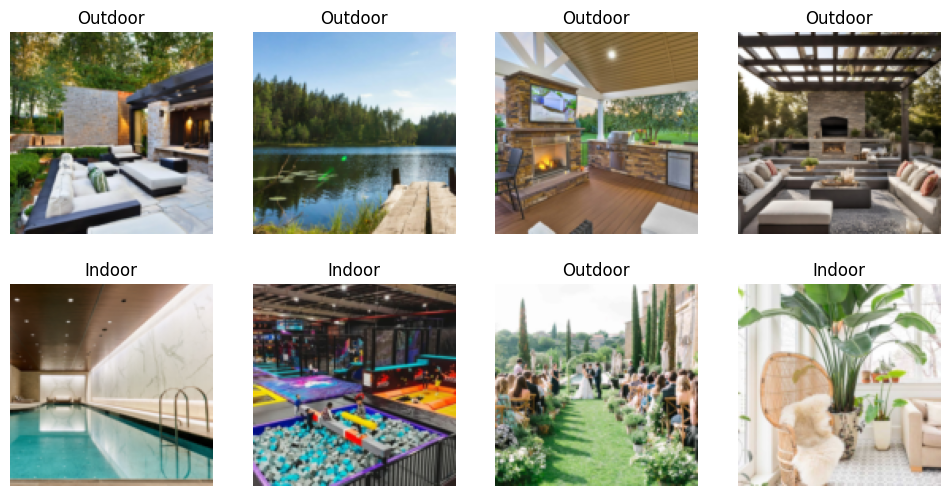

In [32]:
dls.show_batch(max_n=8, nrows=2)

In [33]:
from fastai.vision.all import *
from fastai.vision.widgets import * # <--- Add this line

set_seed(42)
learn = vision_learner(dls, resnet34, metrics=error_rate)

SuggestedLRs(valley=0.0014454397605732083)

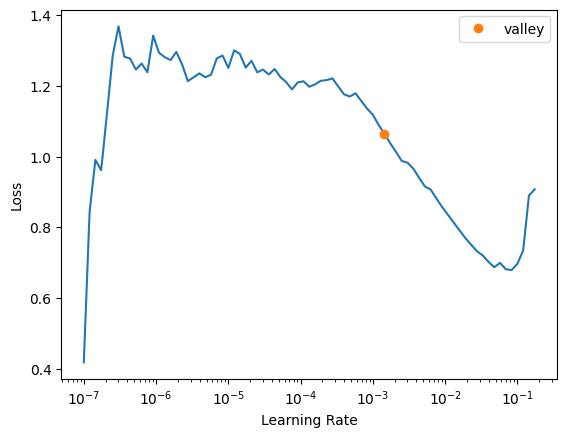

In [34]:
learn.lr_find()

In [35]:
learn.fine_tune(3, 0.0014)

epoch,train_loss,valid_loss,error_rate,time
0,1.349260,0.952031,0.272727,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.711849,0.334331,0.181818,00:08
1,0.631617,0.236709,0.090909,-1:59:58
2,0.464212,0.201387,0.090909,00:02


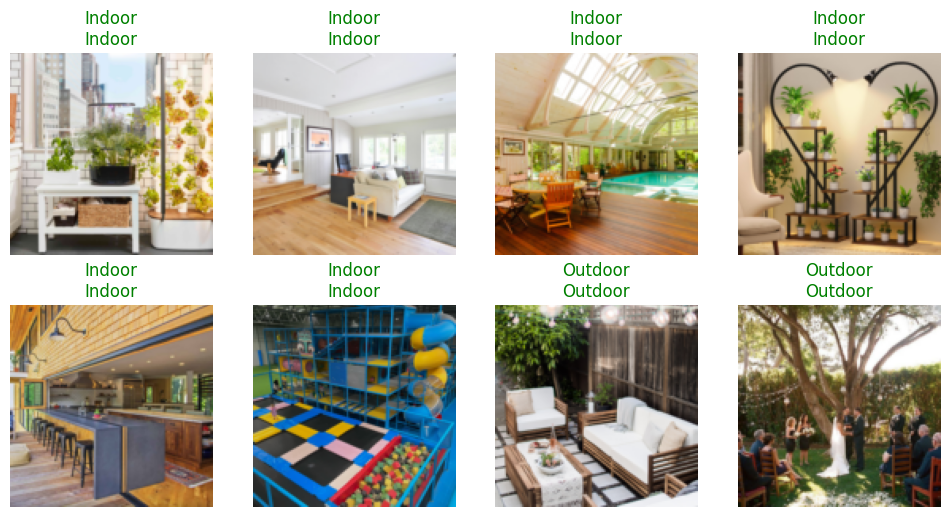

In [36]:
learn.show_results()

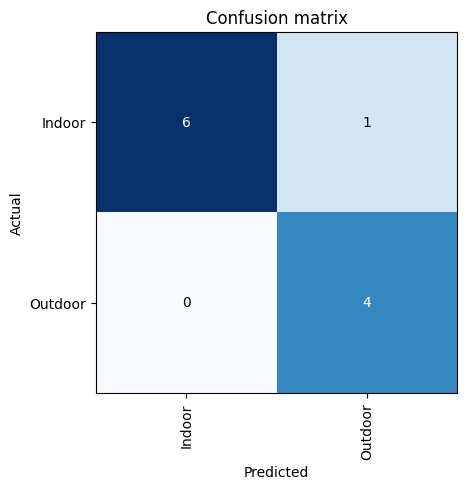

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [39]:
learn.predict('indoor.jpg')

('Indoor', tensor(0), tensor([0.9877, 0.0123]))

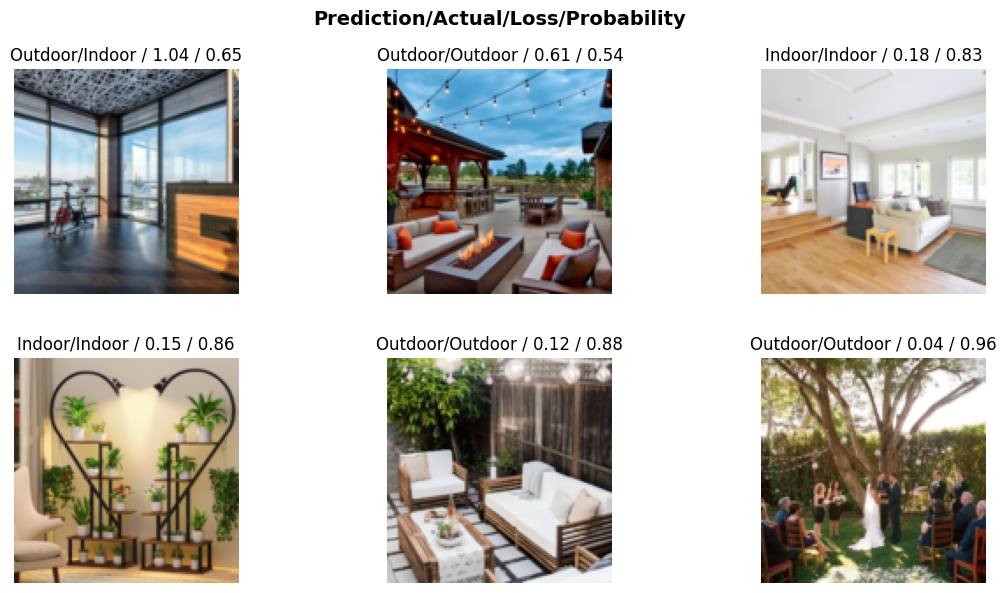

In [40]:
interp.plot_top_losses(6, nrows=2, figsize=(12,6))
plt.tight_layout(h_pad=3)

In [41]:
# cleaner = ImageClassifierCleaner(learn)
# cleaner

In [ ]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [42]:
learn.export('models/indoorclassifier.pkl')